
Training Model Performance Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8077
           1       1.00      1.00      1.00      4155

    accuracy                           1.00     12232
   macro avg       1.00      1.00      1.00     12232
weighted avg       1.00      1.00      1.00     12232

ROC-AUC Score: 1.0000
Confusion Matrix:
[[8077    0]
 [   0 4155]]

Validation Model Performance Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2020
           1       1.00      1.00      1.00      1039

    accuracy                           1.00      3059
   macro avg       1.00      1.00      1.00      3059
weighted avg       1.00      1.00      1.00      3059

ROC-AUC Score: 1.0000
Confusion Matrix:
[[2020    0]
 [   0 1039]]


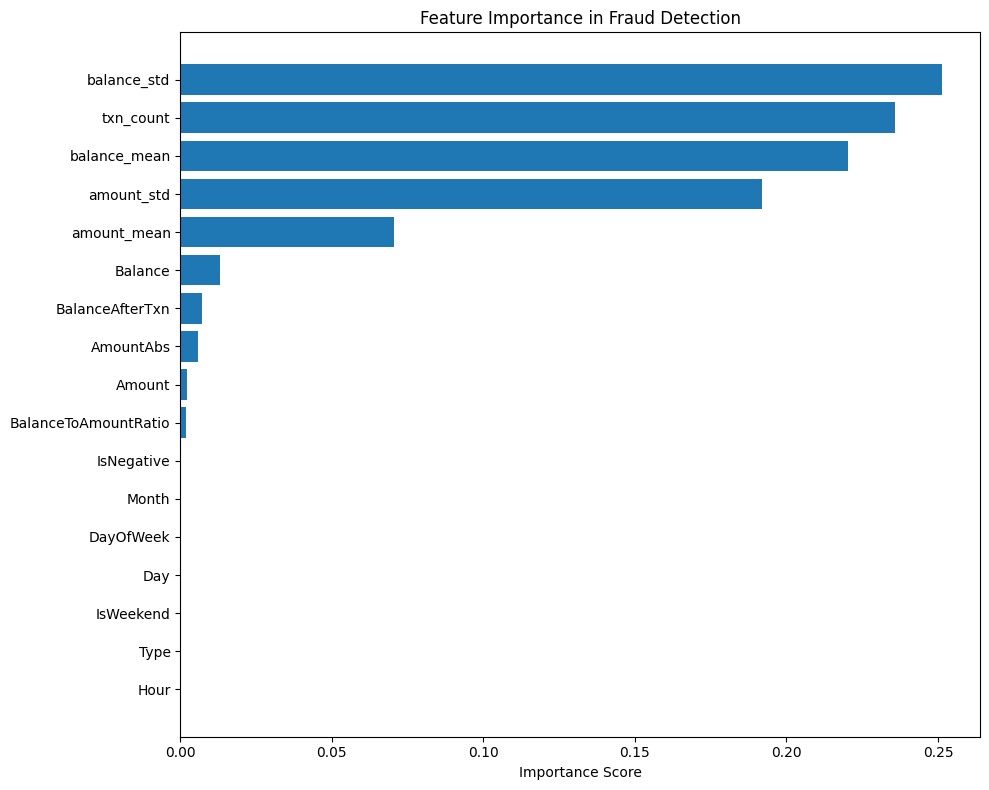


Top 5 Most Important Features:
         feature  importance
16   balance_std    0.251307
12     txn_count    0.235682
15  balance_mean    0.220189
14    amount_std    0.192043
13   amount_mean    0.070476


In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

def create_features(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Hour'] = df['Date'].dt.hour
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    
    df['AmountAbs'] = abs(df['Amount'])
    df['IsNegative'] = (df['Amount'] < 0).astype(int)
    df['BalanceAfterTxn'] = df['Balance'] + df['Amount']
    df['BalanceToAmountRatio'] = df['Balance'] / df['AmountAbs']
    
    return df

def encode_categorical(df):
    le = LabelEncoder()
    df['RealmId'] = le.fit_transform(df['RealmId'])
    df['Type'] = le.fit_transform(df['Type'])
    return df, le

def create_user_features(df):
    user_stats = df.groupby('UserId').agg({
        'Amount': ['count', 'mean', 'std'],
        'Balance': ['mean', 'std']
    }).fillna(0)
    user_stats.columns = ['txn_count', 'amount_mean', 'amount_std', 'balance_mean', 'balance_std']
    return user_stats.reset_index()

df = pd.read_csv('/Users/nc25577_suryateja/Documents/air_pro/model/combined.csv')
df = create_features(df)
df, label_encoder = encode_categorical(df)
user_stats = create_user_features(df)
df = df.merge(user_stats, on='UserId', how='left')


features = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'IsWeekend', 
    'Amount', 'AmountAbs', 'IsNegative', 'Balance',
    'BalanceAfterTxn', 'BalanceToAmountRatio', 'Type',
    'txn_count', 'amount_mean', 'amount_std', 'balance_mean', 'balance_std'
]

X = df[features]
y = df['Fraud']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_model = RandomForestClassifier(
    n_estimators=40,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
train_pred = rf_model.predict(X_train_scaled)
train_pred_proba = rf_model.predict_proba(X_train_scaled)[:, 1]

val_pred = rf_model.predict(X_test_scaled)
val_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]


with open('fraud_detection_model.pkl', 'wb') as model_file:
    pickle.dump(rf_model, model_file)
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)


def print_metrics(y_true, y_pred, y_pred_proba, dataset_type="Validation"):
    print(f"\n{dataset_type} Model Performance Metrics:")
    print(classification_report(y_true, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_true, y_pred_proba):.4f}")
    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix:\n{cm}")

print_metrics(y_train, train_pred, train_pred_proba, "Training")
print_metrics(y_test, val_pred, val_pred_proba, "Validation")

feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance in Fraud Detection')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(feature_importance.tail(5)[::-1])

In [2]:
import pickle
clf = pickle.load(open('/Users/nc25577_suryateja/Documents/air_pro/model/fraud_detection_model.pkl', 'rb'))
clf.__getstate__()['_sklearn_version']

'1.6.1'

In [3]:
import pandas as pd
import numpy as np
import pickle
import sklearn
import matplotlib

versions = {
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "pickle": "Built-in module (no version)",
    "sklearn": sklearn.__version__,
    "matplotlib": matplotlib.__version__
}

versions


{'pandas': '2.2.3',
 'numpy': '2.1.3',
 'pickle': 'Built-in module (no version)',
 'sklearn': '1.6.1',
 'matplotlib': '3.10.0'}

In [5]:
pip install feast

  Using cached feast-0.46.0-py2.py3-none-any.whl.metadata (31 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached protobuf-5.29.3-cp38-abi3-macosx_10_9_universal2.whl.metadata (592 bytes)
  Using cached jinja2-3.1.5-py3-none-any.whl.metadata (2.6 kB)
  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached tenacity-8.5.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached typeguard-4.4.2-py3-none-any.whl.metadata (3.8 kB)
  Using cached uvicorn_worker-0.3.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached gunicorn-23.0.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached prometheus_client-0.21.1-py3-none-any.whl.metadata (1.8 kB)
  Using cached PyJWT-2.10.1-py3-none-any.whl.me